# SVM on SMILES-BERT embeddings

**Goal.** Calibrated linear SVM on 768-dim SMILES-BERT embeddings for cancer vs non-cancer, with consistent validation/test reporting.

- **Data:** `drug_embeddings_final.csv` with `emb_0 … emb_767` and `Label` (0/1)  
- **Why SVM?** Strong linear baseline in high dimensions; fast, stable, and interpretable margins  
- **Why calibration?** Turns SVM scores into probabilities for ROC/PR analysis and thresholding


## Setup

- **Libraries:** `scikit-learn`, `pandas`, `numpy`, `matplotlib`, `seaborn`, `scipy`.
- **Drive (Colab):** mount `/content/drive` to read/write CSVs.

In [1]:
# Imports (core + modeling + metrics)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, auc,
    precision_recall_curve, roc_curve, confusion_matrix,
    classification_report,
)

from scipy.stats import loguniform

In [2]:
# Colab Drive mount (data I/O)
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


## Load data

- Read `drug_embedding_final.csv`.
- Features: 768-bit embedding columns.
- Target: `Label` cast to integer.


In [3]:
# Load the CSV with ECFP fingerprints + Label
df = pd.read_csv('/content/drive/My Drive/ecfp_final.csv')

# Assuming your CSV has columns
X = df[[f'fp_{i}' for i in range(2048)]].values

# Labels
y = df['Label'].astype(int).values


## Data split

- **Validation**: hold out 20% to tune thresholds and report early results.  
- **Train/Test**: split the remaining 80% into 70% train and 10% test.  
- All splits are **stratified** and use `random_state=42`.

In [4]:
# Hold out 20% for validation
X_temp, X_val, y_temp, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Split remaining 80% into train and test
X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.125, stratify=y_temp, random_state=42)

print("Train:", X_train.shape)
print("Test:", X_test.shape)
print("Validation:", X_val.shape)


Train: (8613, 2048)
Test: (1231, 2048)
Validation: (2462, 2048)


## Model pipeline (SVM)

- **Scale:** `StandardScaler(with_mean=True, with_std=True)`  
- **Feature selection (embedded):** `SelectFromModel(LogisticRegression(solver="liblinear", class_weight="balanced", max_iter=1000))`  
  - `threshold ∈ {"median","mean"}`
- **Classifier (with probabilities):**  
  `CalibratedClassifierCV(LinearSVC(class_weight="balanced", random_state=42), method="sigmoid", cv=3)`


In [5]:
# Linear SVM (Calibrated) with FS INSIDE CV
rng = 42

svm_lin_pipe = Pipeline([
    ("scale", StandardScaler()),
    ("select", SelectFromModel(
        LogisticRegression(max_iter=1000, class_weight="balanced", solver="liblinear"),
        threshold="median"   # also tuned below
    )),
    ("svm", CalibratedClassifierCV(
        estimator=LinearSVC(
            class_weight="balanced",
            random_state=rng
        ),
        method="sigmoid",   # or 'isotonic' (needs more data)
        cv=3                # internal calibration CV
    ))
])

param_dist_lin = {
    "select__threshold": ["median", "mean"],
    "svm__estimator__C": loguniform(1e-3, 1e2),
    "svm__method": ["sigmoid"],                       # add 'isotonic' if dataset is large
}

cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=rng)

svm_lin_search = RandomizedSearchCV(
    estimator=svm_lin_pipe,
    param_distributions=param_dist_lin,
    n_iter=25,
    scoring="average_precision",   # PR-AUC
    cv=cv,
    n_jobs=-1,
    verbose=1,
    random_state=rng
)

svm_lin_search.fit(X_train, y_train)
best_svm_lin = svm_lin_search.best_estimator_
print("Best params (Linear SVM):", svm_lin_search.best_params_)

# Probabilities
y_val_prob  = best_svm_lin.predict_proba(X_val)[:, 1]
y_test_prob = best_svm_lin.predict_proba(X_test)[:, 1]

Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best params (Linear SVM): {'select__threshold': 'median', 'svm__estimator__C': np.float64(0.001201797402730995), 'svm__method': 'sigmoid'}


## Validation results (default threshold 0.50)

- Predictions via for `thr=0.50`.  
- Metrics reported:
  - **Accuracy**, **Precision**, **Recall**, **F1**  
  - **ROC AUC** and **PR AUC** (threshold-free)  
- Include a **confusion matrix** heatmap with readable axis labels.


,Set,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC
0,SVM Validation (thr=0.50 default),0.980097,0.3,0.066667,0.109091,0.720664,0.143497


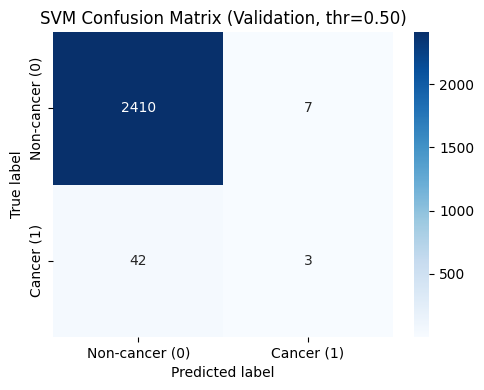

In [6]:
# Validation @ Default Threshold (0.5)
y_val_pred_050 = (y_val_prob >= 0.50).astype(int)

df_svm_val_050 = pd.DataFrame([{
    "Set": "SVM Validation (thr=0.50 default)",
    "Accuracy":  accuracy_score(y_val, y_val_pred_050),
    "Precision": precision_score(y_val, y_val_pred_050, zero_division=0),
    "Recall":    recall_score(y_val, y_val_pred_050),
    "F1 Score":  f1_score(y_val, y_val_pred_050),
    "ROC AUC":   roc_auc_score(y_val, y_val_prob),
    "PR AUC":    average_precision_score(y_val, y_val_prob)
}])
display(df_svm_val_050)

cm = confusion_matrix(y_val, y_val_pred_050)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-cancer (0)", "Cancer (1)"],
            yticklabels=["Non-cancer (0)", "Cancer (1)"])
plt.title("SVM Confusion Matrix (Validation, thr=0.50)")
plt.ylabel("True label"); plt.xlabel("Predicted label")
plt.tight_layout(); plt.show()

## Threshold tuning by F1

- Sweep candidate thresholds from unique predicted probabilities.  
- Choose the threshold that **maximizes F1** on the validation set.  
- Recompute **Accuracy**, **Precision**, **Recall**, **F1**, **ROC AUC**, **PR AUC** at the tuned threshold.  
- Show a confusion matrix at the tuned operating point.


,Set,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC
0,SVM Validation (thr=tuned=0.191),0.974411,0.304348,0.311111,0.307692,0.720664,0.143497


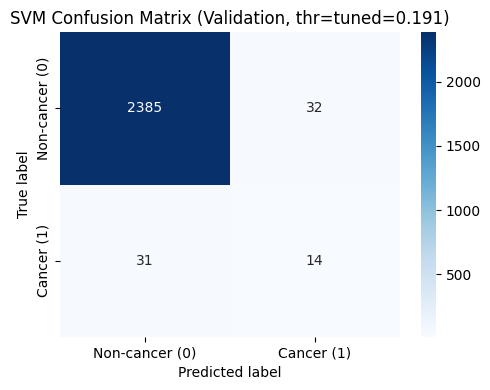

In [7]:
# Validation @ Tuned Threshold (F1-optimal)
# Find tuned threshold from PR curve (indexing-safe)
prec_v, rec_v, thr_v = precision_recall_curve(y_val, y_val_prob)
f1_v = (2 * prec_v[:-1] * rec_v[:-1]) / (prec_v[:-1] + rec_v[:-1] + 1e-12)
best_idx = int(np.argmax(f1_v))
svm_tuned_thr = float(thr_v[best_idx])

y_val_pred_tuned = (y_val_prob >= svm_tuned_thr).astype(int)

df_svm_val_tuned = pd.DataFrame([{
    "Set": f"SVM Validation (thr=tuned={svm_tuned_thr:.3f})",
    "Accuracy":  accuracy_score(y_val, y_val_pred_tuned),
    "Precision": precision_score(y_val, y_val_pred_tuned, zero_division=0),
    "Recall":    recall_score(y_val, y_val_pred_tuned),
    "F1 Score":  f1_score(y_val, y_val_pred_tuned),
    "ROC AUC":   roc_auc_score(y_val, y_val_prob),
    "PR AUC":    average_precision_score(y_val, y_val_prob)
}])
display(df_svm_val_tuned)

cm = confusion_matrix(y_val, y_val_pred_tuned)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-cancer (0)", "Cancer (1)"],
            yticklabels=["Non-cancer (0)", "Cancer (1)"])
plt.title(f"SVM Confusion Matrix (Validation, thr=tuned={svm_tuned_thr:.3f})")
plt.ylabel("True label"); plt.xlabel("Predicted label")
plt.tight_layout(); plt.show()

## Screening scenario (fixed threshold = 0.20)

- Lowering the threshold increases recall at the cost of precision—useful for screening.  
- Evaluate the validation set at `thr = 0.20` and report the same metric table plus a confusion matrix.


,Set,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC
0,SVM Validation (thr=0.20 screening),0.974411,0.285714,0.266667,0.275862,0.720664,0.143497


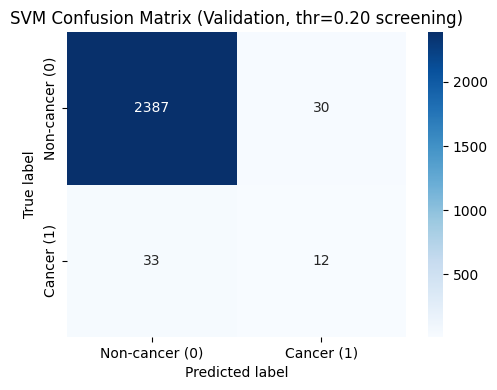

In [8]:
# Validation @ 0.2
# Probabilities
thr_screen = 0.20
y_val_pred_020 = (y_val_prob >= thr_screen).astype(int)

df_svm_val_020 = pd.DataFrame([{
    "Set": "SVM Validation (thr=0.20 screening)",
    "Accuracy":  accuracy_score(y_val, y_val_pred_020),
    "Precision": precision_score(y_val, y_val_pred_020, zero_division=0),
    "Recall":    recall_score(y_val, y_val_pred_020),
    "F1 Score":  f1_score(y_val, y_val_pred_020),
    "ROC AUC":   roc_auc_score(y_val, y_val_prob),
    "PR AUC":    average_precision_score(y_val, y_val_prob)
}])
display(df_svm_val_020)

cm = confusion_matrix(y_val, y_val_pred_020)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-cancer (0)", "Cancer (1)"],
            yticklabels=["Non-cancer (0)", "Cancer (1)"])
plt.title("SVM Confusion Matrix (Validation, thr=0.20 screening)")
plt.ylabel("True label"); plt.xlabel("Predicted label")
plt.tight_layout(); plt.show()

## Recall-targeted operating point

- Select the **smallest** threshold that achieves a target recall (e.g., `recall ≥ 0.70`), keeping precision as high as possible.  
- If the target is unattainable, fall back to `thr = 0.20`.  
- Report metrics and confusion matrix for this recall-targeted point.


,Set,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC
0,"SVM Validation (recall≥0.70, thr=0.010)",0.654346,0.036782,0.711111,0.069945,0.720664,0.143497


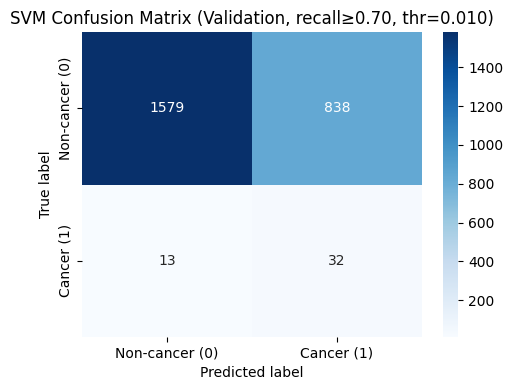

In [9]:
# Pick the largest τ meeting the target recall
target_recall = 0.70
prec_v, rec_v, thr_v = precision_recall_curve(y_val, y_val_prob)   # len(thr_v) = len(rec_v) - 1
mask = rec_v[:-1] >= target_recall
if mask.any():
    idx = np.where(mask)[0][-1]        # largest τ that still meets the target
    svm_thr_recall = float(thr_v[idx])
else:
    svm_thr_recall = 0.20               # fallback if unattainable

y_val_pred_recall = (y_val_prob >= svm_thr_recall).astype(int)

df_svm_val_recall = pd.DataFrame([{
    "Set": f"SVM Validation (recall≥{target_recall:.2f}, thr={svm_thr_recall:.3f})",
    "Accuracy":  accuracy_score(y_val, y_val_pred_recall),
    "Precision": precision_score(y_val, y_val_pred_recall, zero_division=0),
    "Recall":    recall_score(y_val, y_val_pred_recall),
    "F1 Score":  f1_score(y_val, y_val_pred_recall),
    "ROC AUC":   roc_auc_score(y_val, y_val_prob),
    "PR AUC":    average_precision_score(y_val, y_val_prob)
}])
display(df_svm_val_recall)

cm = confusion_matrix(y_val, y_val_pred_recall)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Non-cancer (0)", "Cancer (1)"],
            yticklabels=["Non-cancer (0)", "Cancer (1)"])
plt.title(f"SVM Confusion Matrix (Validation, recall≥{target_recall:.2f}, thr={svm_thr_recall:.3f})")
plt.ylabel("True label"); plt.xlabel("Predicted label")
plt.tight_layout(); plt.show()

## Threshold sweep on validation — Methods

- **Procedure:** thresholds from `0.05` to `0.95` in steps of `0.05`.  
  For each `τ`, compute on the validation set:  
  `Precision(τ)`, `Recall(τ)`, and `F1(τ)` using `y_prob` and `ŷ = [p ≥ τ]`.
- **Plot:** three line series (Precision, Recall, F1) with markers.  
  Vertical reference lines mark key operating points:
  - `τ = 0.50` (default)
  - `τ = 0.20` (screening)
  - `τ = tuned_thr` (max-F1)
  - `τ = thr_recall` (recall-targeted)
- **Figure details:** title *“Precision / Recall / F1 vs Threshold • Validation”*,  
  x-axis = **Threshold**, y-axis = **Score**, legend on, grid enabled.

**Figure.** Precision (P), Recall (R), and F1 across thresholds, with dashed lines at chosen operating points.


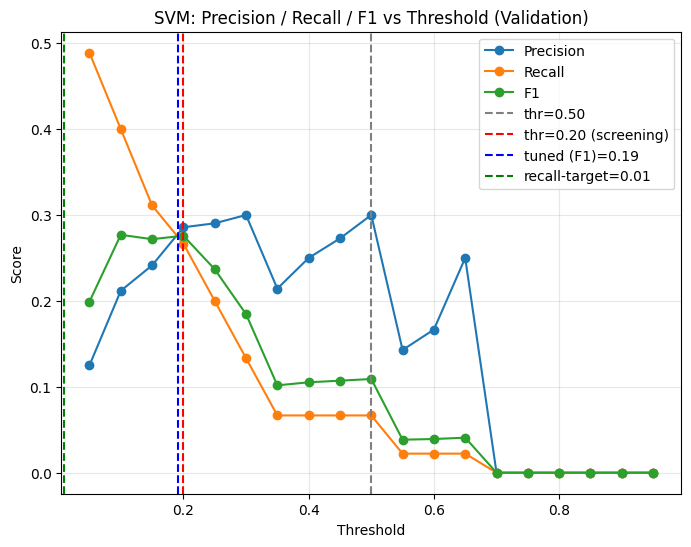

In [10]:
# Sweep discrete thresholds for plotting
thresholds = np.arange(0.05, 0.96, 0.05)
precisions, recalls, f1s = [], [], []
for thr in thresholds:
    y_pred_thr = (y_val_prob >= thr).astype(int)
    precisions.append(precision_score(y_val, y_pred_thr, zero_division=0))
    recalls.append(recall_score(y_val, y_pred_thr))
    f1s.append(f1_score(y_val, y_pred_thr))

# Plot (consistent with LR/RF/XGB/MLP)
plt.figure(figsize=(8,6))
plt.plot(thresholds, precisions, marker='o', label='Precision')
plt.plot(thresholds, recalls,   marker='o', label='Recall')
plt.plot(thresholds, f1s,       marker='o', label='F1')

# Reference lines
plt.axvline(0.50,            color='grey',  linestyle='--', label='thr=0.50')
plt.axvline(0.20,            color='red',   linestyle='--', label='thr=0.20 (screening)')
plt.axvline(svm_tuned_thr,   color='blue',  linestyle='--', label=f'tuned (F1)={svm_tuned_thr:.2f}')
plt.axvline(svm_thr_recall,  color='green', linestyle='--', label=f'recall-target={svm_thr_recall:.2f}')

plt.title('SVM: Precision / Recall / F1 vs Threshold (Validation)')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

## ROC curve — Validation

- **Computation:** `fpr, tpr = roc_curve(y_val, y_val_prob)` with `roc_auc_val = auc(fpr, tpr)`.  
- **Plot:** TPR vs FPR with the diagonal `y = x` as a reference (no-skill).  
- **Reading the figure:** curves further above the diagonal indicate better ranking of positives over negatives; **AUC** summarizes this ranking independent of any threshold.


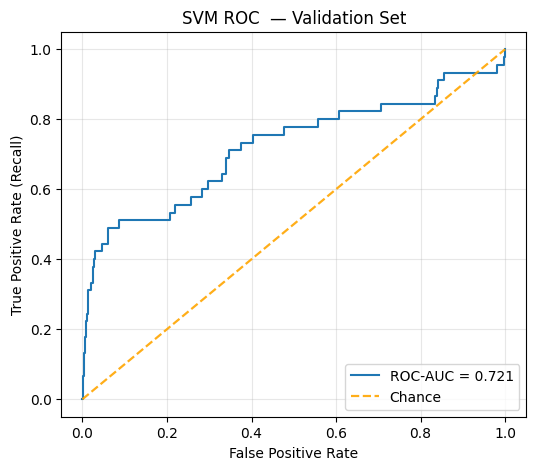

In [11]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_val, y_val_prob)
roc_auc_val = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"ROC-AUC = {roc_auc_val:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="orange", lw=1.6, alpha=0.9, label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("SVM ROC  — Validation Set")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()


## Precision–Recall (PR) curve — Validation

- **Computation:** `prec, rec, _ = precision_recall_curve(y_val, y_val_prob)` and **Average Precision (AP)** via `average_precision_score(y_val, y_val_prob)`.  
- **Plot:** Precision vs Recall; AP is shown in the legend.  
- **Reading the figure:** with class imbalance, PR curves are more informative than ROC.  
  The **baseline precision** equals the positive prevalence `π = (#positives / #samples)`; curves well above this line indicate useful enrichment.



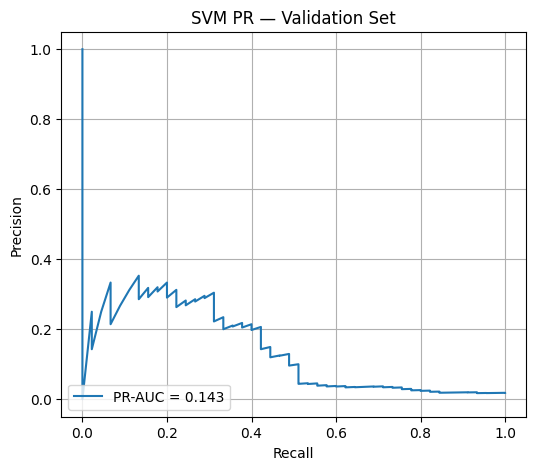

Validation ROC-AUC = 0.721 | PR-AUC = 0.143


In [12]:
# PR Curve
prec, rec, _ = precision_recall_curve(y_val, y_val_prob)
pr_auc_val = average_precision_score(y_val, y_val_prob)

plt.figure(figsize=(6,5))
plt.plot(rec, prec, label=f"PR-AUC = {pr_auc_val:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("SVM PR — Validation Set")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

print(f"Validation ROC-AUC = {roc_auc_val:.3f} | PR-AUC = {pr_auc_val:.3f}")

## Test-set evaluation

**Goal:** apply the model (fixed from training/validation) to the held-out **test set** and report performance at several operating points.

- **Thresholds evaluated:**
  - `τ = tuned_thr` (chosen on **validation** by max-F1)  
  - `τ = 0.50` (default)  
  - `τ = 0.20` (screening)  
  - `τ = thr_recall` (smallest τ that met the recall target on validation)
- **Leakage control:** thresholds are **carried over from validation**; no re-tuning on test.


SVM TEST • Threshold-free
ROC-AUC: 0.652 | PR-AUC: 0.052


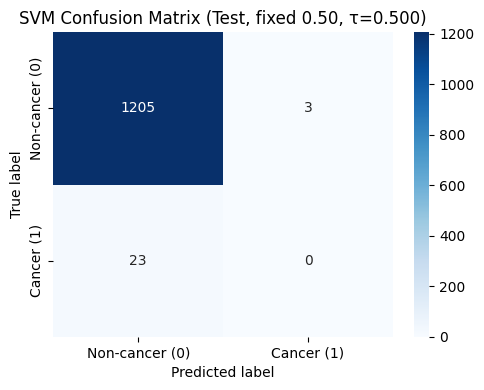

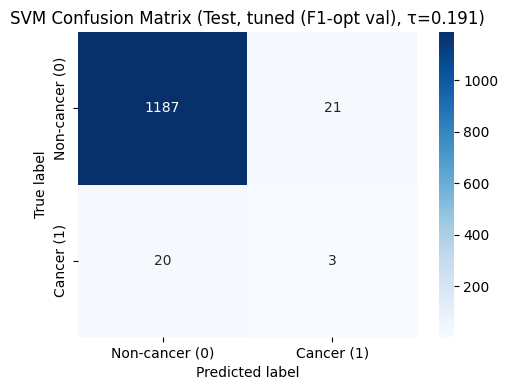

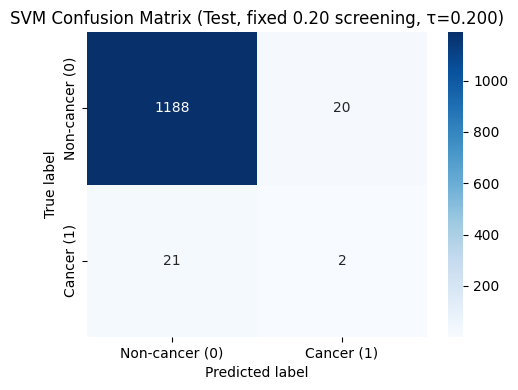

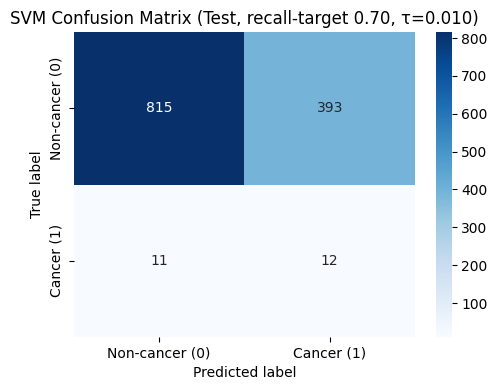

,Set,Accuracy,Precision,Recall,F1 Score,ROC AUC,PR AUC
0,"SVM Test (fixed 0.50, τ=0.500)",0.978879,0.000000,0.000000,0.000000,0.651706,0.052405
1,"SVM Test (tuned (F1-opt val), τ=0.191)",0.966694,0.125000,0.130435,0.127660,0.651706,0.052405
2,"SVM Test (fixed 0.20 screening, τ=0.200)",0.966694,0.090909,0.086957,0.088889,0.651706,0.052405
3,"SVM Test (recall-target 0.70, τ=0.010)",0.671812,0.029630,0.521739,0.056075,0.651706,0.052405


In [13]:
# TEST SET EVALUATION
roc_auc_test = roc_auc_score(y_test, y_test_prob)
pr_auc_test  = average_precision_score(y_test, y_test_prob)
print("SVM TEST • Threshold-free")
print(f"ROC-AUC: {roc_auc_test:.3f} | PR-AUC: {pr_auc_test:.3f}")

# Helper: evaluate + plot (same style as other models) ---
def evaluate_and_plot_svm_test(y_true, y_prob, thr_value, label):
    y_pred = (y_prob >= thr_value).astype(int)
    row = {
        "Set":       f"SVM Test ({label}, τ={thr_value:.3f})",
        "Accuracy":  accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall":    recall_score(y_true, y_pred),
        "F1 Score":  f1_score(y_true, y_pred),
        "ROC AUC":   roc_auc_score(y_true, y_prob),           # threshold-free
        "PR AUC":    average_precision_score(y_true, y_prob)  # threshold-free
    }
    df = pd.DataFrame([row])

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(
        cm, annot=True, fmt='d', cmap='Blues',
        xticklabels=["Non-cancer (0)", "Cancer (1)"],
        yticklabels=["Non-cancer (0)", "Cancer (1)"]
    )
    plt.title(f"SVM Confusion Matrix (Test, {label}, τ={thr_value:.3f})")
    plt.ylabel("True label"); plt.xlabel("Predicted label")
    plt.tight_layout(); plt.show()
    return df

# Evaluate at 0.50, tuned (F1-opt from val), 0.20, and recall-target
tables_svm_test = []
tables_svm_test.append(evaluate_and_plot_svm_test(y_test, y_test_prob, 0.50,       "fixed 0.50"))
tables_svm_test.append(evaluate_and_plot_svm_test(y_test, y_test_prob, svm_tuned_thr,  "tuned (F1-opt val)"))
tables_svm_test.append(evaluate_and_plot_svm_test(y_test, y_test_prob, 0.20,       "fixed 0.20 screening"))
tables_svm_test.append(evaluate_and_plot_svm_test(y_test, y_test_prob, svm_thr_recall, f"recall-target {target_recall:.2f}"))

# Compact combined table
svm_test_summary = pd.concat(tables_svm_test, ignore_index=True)
display(svm_test_summary)

## ROC curve — Test Set

- **Computation:** `fpr_t, tpr_t, _ = roc_curve(y_test, y_test_prob)` and `roc_auc_test = auc(fpr_t, tpr_t)`.  
- **Display:** plot TPR vs FPR with the diagonal `y = x` as the no-skill reference.  
- **Interpretation:** the farther the curve bows above the diagonal, the better the ranking of positives over negatives. AUC summarizes this ranking and is **threshold-free**.


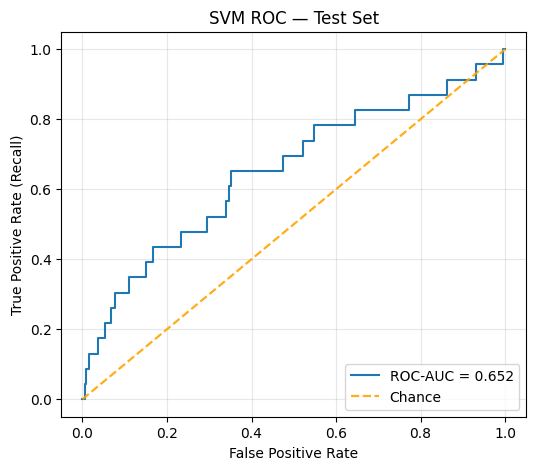

In [14]:
# ROC curve
fpr_t, tpr_t, _ = roc_curve(y_test, y_test_prob)
roc_auc_test = auc(fpr_t, tpr_t)

plt.figure(figsize=(6,5))
plt.plot(fpr_t, tpr_t, label=f"ROC-AUC = {roc_auc_test:.3f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="orange", lw=1.6, alpha=0.9, label="Chance")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("SVM ROC — Test Set")
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)
plt.show()


## Precision–Recall (PR) curve — Test Set

- **Computation:** `prec_t, rec_t, _ = precision_recall_curve(y_test, y_test_prob)` and **Average Precision (AP)** via `average_precision_score(y_test, y_test_prob)`.  
- **Display:** Precision vs Recall with AP shown in the legend.  
- **Interpretation:** PR is more informative than ROC under class imbalance. The implicit baseline equals the positive prevalence; curves well above baseline indicate useful enrichment.


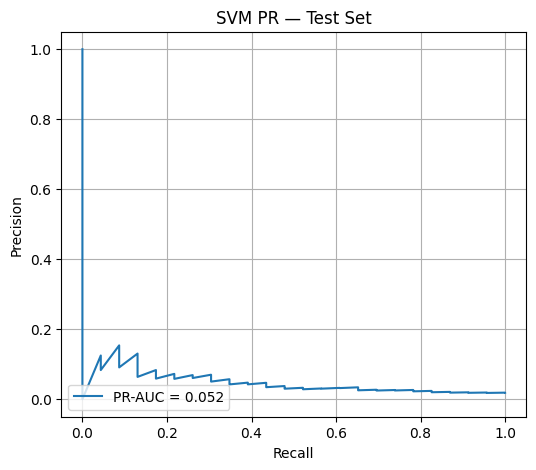

Test ROC-AUC = 0.652 | PR-AUC = 0.052


In [15]:
# PR curve
prec_t, rec_t, _ = precision_recall_curve(y_test, y_test_prob)
pr_auc_test = average_precision_score(y_test, y_test_prob)

plt.figure(figsize=(6,5))
plt.plot(rec_t, prec_t, label=f"PR-AUC = {pr_auc_test:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("SVM PR — Test Set")
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

print(f"Test ROC-AUC = {roc_auc_test:.3f} | PR-AUC = {pr_auc_test:.3f}")
